# PatchCNN

Ce notebook évalue différent Patch-CNN pour faire de la classification pixelwise des classes chondritiques.

Le principe d'un Patch CNN est qu'il n'y a pas de couche linéaire à la fin + softmax, le réseau est complètement convolutionnel. C'est en gros un encodeur.

L'avantage est que l'entrée peut être de taille variable et qu'il y a besoin de moins de données. Car si on partait sur un UNet il faudrait des images entières annotés ce que nous ne disposons pas, on possède juste des pixels à droite à gauche.

L'idée est donc de prendre nos pixels à droite à gauche, d'avoir une fenêtre autour d'eux et de les envoyer dans notre réseau. La sortie du réseau est une image d'à peu près la même taille que l'entrée, mais à N dimensions, où N est le nombre de classe. On prend le pixel au centre et on prend argmax des canaux, ça nous donne la classe majoritaire (c'est un peu bourrin on assume direct que l'espace latent = prédiction des classes).

Les features d'entrées sont:
- BSE
- 7 * EDS

Early fusion and mid fusion sont testé.

Les modèles sont entraînés par cross-validation. Une évaluation visuelle est faîte à la fin sur une image entière.

---

# Chargement

In [1]:
import ipywidgets as widgets
from ipywidgets import interact
from src.metrics import *
from src.utils import *
from PIL import Image
import cv2
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset, random_split
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

On charge les données de train et de test construit par le notebook labels et ensuite on shift les y pour que le premiers indices soit a 0.

In [2]:
X_train = np.load('output/X.npy')
y_train = np.load('output/y.npy')
X_test  = np.load('output/X_test.npy')
y_test  = np.load('output/y_test.npy')

if 11 in np.unique(y_train):
    y_train = y_train - 1
    y_test = y_test - 1

print("Train:", X_train.shape, y_train.shape)
print("Test :", X_test.shape, y_test.shape)

labels = [
    "Type I",
    "Type II",
    "Matrix",
    "Mesostase",
    "Mesostase II",
    "CAIs",
    "Carbonate",
    "Sulfur",
    "FeO",
    "Fe",
    "Epoxy"
]

Train: (33919, 9, 9, 8) (33919,)
Test : (19398, 9, 9, 8) (19398,)


On fait un petit peu de nettoyage:
- On fusionne les labels type I et mesostase type I ensemble
- Pareil pour type II et mesostase type II
- On supprime les carbonates (trop chiant)

In [3]:
labels = [
    "Type I",
    "Type II",
    "Matrix",
    "CAIs",
    "Sulfur",
    "FeO",
    "Fe",
    "Epoxy"
]

# type I (0) + mesostase (3) = 0
# type II (1) + mesostase II (4) = 1
# Carbonate (6) = delete
def remap_labels(y):
    y_new = np.full_like(y, fill_value=255)

    # Fusion
    y_new[(y == 0) | (y == 3)] = 0
    y_new[(y == 1) | (y == 4)] = 1

    mapping = {
        2: 2,  # Matrix
        5: 3,  # CAIs
        7: 4,  # Sulfur
        8: 5,  # FeO
        9: 6,  # Fe
        10: 7  # Epoxy
    }

    for old, new in mapping.items():
        y_new[y == old] = new

    return y_new

def merge_and_clean(X_train, y_train, X_test, y_test):
    y_train_new = remap_labels(y_train)
    y_test_new  = remap_labels(y_test)
    
    train_mask = y_train_new != 255
    test_mask  = y_test_new != 255
    
    X_train_new = X_train[train_mask]
    y_train_new = y_train_new[train_mask]
    
    X_test_new  = X_test[test_mask]
    y_test_new  = y_test_new[test_mask]

    return X_train_new, y_train_new, X_test_new, y_test_new

X_train, y_train, X_test, y_test = merge_and_clean(X_train, y_train, X_test, y_test)
print("Train:", X_train.shape, y_train.shape)
print("Test :", X_test.shape, y_test.shape)

Train: (29919, 9, 9, 8) (29919,)
Test : (18038, 9, 9, 8) (18038,)


---

# Agent definition

On commence par définir l'architecture.

In [4]:
import torch.nn as nn

def make_activation(name):
    name = name.lower()
    activations = {
        "relu": nn.ReLU(inplace=True),
        "leaky_relu": nn.LeakyReLU(0.01, inplace=True),
        "elu": nn.ELU(inplace=True),
        "gelu": nn.GELU(),
        "silu": nn.SiLU(),
        "mish": nn.Mish(),
    }

    if name not in activations:
        raise ValueError(f"Unknown activation: {name}")

    return activations[name]

class ConvBlock(nn.Module):
    def __init__(
        self,
        in_channels: int,
        latent_dims: list[int],
        activation: str,
    ):
        super().__init__()

        layers = []
        act = make_activation(activation)
        c = in_channels

        for c_out in latent_dims:
            layers += [
                nn.Conv2d(c, c_out, kernel_size=3, padding=1),
                act,
            ]
            c = c_out

        self.net = nn.Sequential(*layers)
        self.out_channels = c

    def forward(self, x):
        return self.net(x)

class EarlyCNN(nn.Module):
    def __init__(
        self,
        in_channels: int,
        latent_dims: list[int],
        num_classes: int,
        activation: str = "relu",
    ):
        super().__init__()

        self.features = ConvBlock(
            in_channels,
            latent_dims,
            activation,
        )

        self.head = nn.Conv2d(
            self.features.out_channels,
            num_classes,
            kernel_size=1,
            padding=0,
        )

    def forward(self, x):
        return self.head(self.features(x))

class MidFusionCNN(nn.Module):
    def __init__(
        self,
        latent_dims_branch1: list[int],
        latent_dims_branch2: list[int],
        fusion_latent_dims: list[int],
        num_classes: int,
        activation: str = "relu",
    ):
        super().__init__()

        self.branch1 = ConvBlock(1, latent_dims_branch1, activation)
        self.branch2 = ConvBlock(7, latent_dims_branch2, activation)

        fusion_in = self.branch1.out_channels + self.branch2.out_channels

        self.fusion = ConvBlock(
            fusion_in,
            fusion_latent_dims,
            activation,
        )

        self.head = nn.Conv2d(
            self.fusion.out_channels,
            num_classes,
            kernel_size=1,
            padding=0,
        )

    def forward(self, x):
        b1 = self.branch1(x[:, :1])
        b2 = self.branch2(x[:, 1:])
        return self.head(self.fusion(torch.cat([b1, b2], dim=1)))

Ensuite le dataset, on swap les dimensions pour match l'ordre torch pour les batchs.

In [5]:
class PatchDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        x = torch.tensor(self.X[idx], dtype=torch.float32).permute(2,0,1)
        y = torch.tensor(self.y[idx], dtype=torch.long)
        return x, y

On définit la classe Agent qui encapsule toute la logique d'entrainement + cross-validation

In [8]:
class Agent:
    def __init__(self, model_cls, device, center_mode):
        self.model_cls = model_cls
        self.device = device
        self.center_mode = center_mode

    def forward(self, model, xb):
        out = model(xb)

        if self.center_mode:
            H, W = out.shape[2], out.shape[3]
            return out[:, :, H // 2, W // 2]
        else:
            return out.mean(dim=[2,3])

    def train_one_epoch(self, model, loader, criterion, optimizer):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for xb, yb in loader:
            xb, yb = xb.to(self.device), yb.to(self.device)
            
            optimizer.zero_grad()
            out = self.forward(model, xb)

            loss = criterion(out, yb)
            
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item() * xb.size(0)
            preds = out.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)
            
        return total_loss/total, correct/total

    def eval_model(self, model, loader, criterion):
        model.eval()
        total_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for xb, yb in loader:
                xb, yb = xb.to(self.device), yb.to(self.device)
                
                out = self.forward(model, xb)
                loss = criterion(out, yb)
                
                total_loss += loss.item() * xb.size(0)
                preds = out.argmax(dim=1)
                correct += (preds == yb).sum().item()
                total += yb.size(0)
                
        return total_loss/total, correct/total

    def train(self, train_ds, val_ds, num_epochs=15, batch_size=64, lr=1e-3, patience=5):
        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)
        val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2)

        model = self.model_cls().to(self.device)
    
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        train_losses, val_losses = [], []
        train_accs, val_accs = [], []

        epochs_no_improve = 0
        best_val_loss = float("inf")
        for epoch in range(num_epochs):
            train_loss, train_acc = self.train_one_epoch(model, train_loader, criterion, optimizer)
            val_loss, val_acc = self.eval_model(model, val_loader, criterion)
    
            print(f"Epoch {epoch+1}/{num_epochs} | "
                  f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
                  f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accs.append(train_acc)
            val_accs.append(val_acc)

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_state = copy.deepcopy(model.state_dict())
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
            
            if epochs_no_improve >= patience:
                break
    
        return {
            "train_losses": train_losses,
            "val_losses": val_losses,
            "train_accs": train_accs,
            "val_accs": val_accs,
            "best_val_loss": best_val_loss,
            "model_state": best_model_state
        }

    def cross_validate(self, X, y, k=5, num_epochs=15, batch_size=64, lr=1e-3, patience=5):
        dataset = PatchDataset(X, y)
        self.fold_results = []

        self.num_classes = len(np.unique(y))
        self.in_channels = X.shape[-1]
        
        if k == 1:
            train_ratio = 0.8
            n_total = len(dataset)
            n_train = int(train_ratio * n_total)
            n_eval = n_total - n_train
            
            train_ds, val_ds = random_split(
                dataset,
                [n_train, n_eval],
                generator=torch.Generator().manual_seed(42)
            )
            
            res = self.train(train_ds, val_ds, num_epochs, batch_size, lr)
        
            self.fold_results.append(res)
            print(f"Training best Val Loss: {res['best_val_loss']:.4f}")
        else:      
            kf = KFold(n_splits=k, shuffle=True, random_state=42)
        
            for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
                print(f"\n--- Fold {fold+1}/{k} ---")
                train_ds = Subset(dataset, train_idx)
                val_ds   = Subset(dataset, val_idx)
    
                res = self.train(train_ds, val_ds, num_epochs, batch_size, lr)
        
                self.fold_results.append(res)
                print(f"Fold {fold+1} best Val Loss: {res['best_val_loss']:.4f}")

        return self.fold_results

---

# Entraînement

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

agent = Agent(
    model_cls=lambda: EarlyCNN(
        in_channels=8,
        latent_dims=[32, 64],
        num_classes=8,
        activation="silu",
    ),
    device=device,
    center_mode=True
)

_ = agent.cross_validate(X_train, y_train, k=1, num_epochs=5, batch_size=64)

Epoch 1/5 | Train Loss: 0.2443, Acc: 0.9447 | Val Loss: 0.0932, Acc: 0.9652
Epoch 2/5 | Train Loss: 0.0729, Acc: 0.9756 | Val Loss: 0.0500, Acc: 0.9804
Epoch 3/5 | Train Loss: 0.0521, Acc: 0.9820 | Val Loss: 0.0617, Acc: 0.9773
Epoch 4/5 | Train Loss: 0.0485, Acc: 0.9837 | Val Loss: 0.0395, Acc: 0.9851
Epoch 5/5 | Train Loss: 0.0466, Acc: 0.9843 | Val Loss: 0.0351, Acc: 0.9871
Training best Val Loss: 0.0351


On regarde la fenêtre de confusion sur le jeu de test.

Test Loss: 0.0512, Test Accuracy: 0.9856


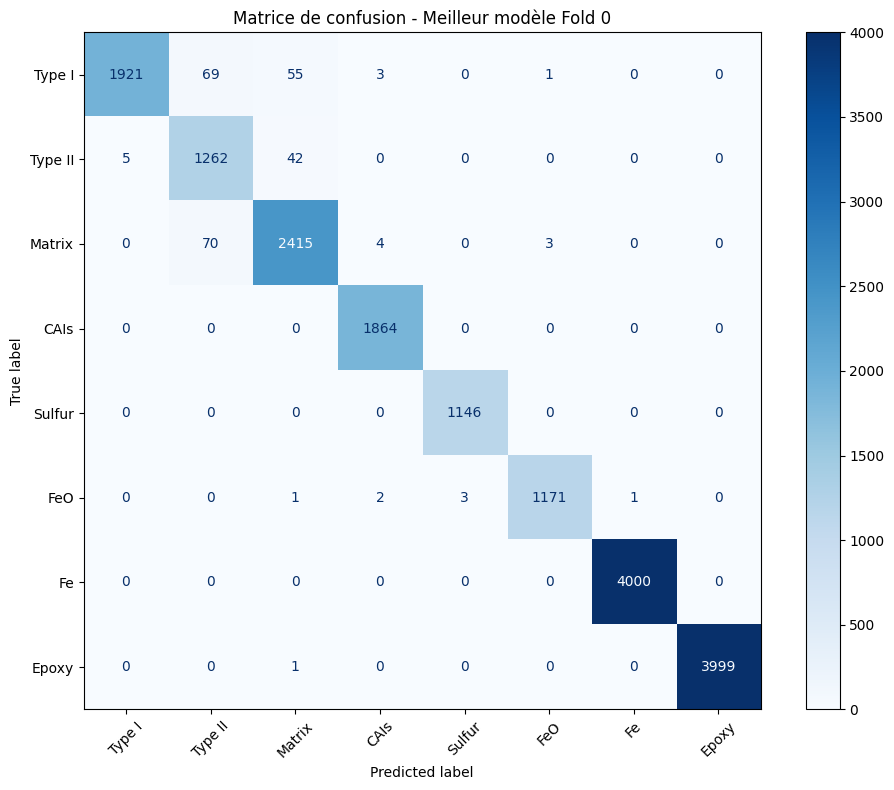

In [38]:
def test(X_test, y_test, model, device, path=None):
    test_ds = PatchDataset(X_test, y_test)
    test_loader = torch.utils.data.DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=2)
    
    all_preds = []
    all_labels = []
    
    criterion = torch.nn.CrossEntropyLoss()
    test_loss, total_correct, total_samples = 0, 0, 0
    
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)

            out = agent.forward(model, xb)

            loss = criterion(out, yb)
            test_loss += loss.item() * xb.size(0)
    
            preds = out.argmax(dim=1)
            all_preds.append(preds.cpu())
            all_labels.append(yb.cpu())
            total_correct += (preds == yb).sum().item()
            total_samples += yb.size(0)
    
    test_loss /= total_samples
    test_acc = total_correct / total_samples
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")
    
    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()
    
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(cm, display_labels=labels)
    
    plt.figure(figsize=(10,8))
    disp.plot(cmap=plt.cm.Blues, values_format='d', ax=plt.gca())
    plt.title("Matrice de confusion - Meilleur modèle Fold 0")
    plt.xticks(rotation=45)
    plt.tight_layout()
    if path is None:
        plt.show()
    else:
        plt.savefig(path + "/confusion_matrix.png", dpi=200, bbox_inches='tight')
        plt.close()

    return None

best = agent.fold_results[0]

model = agent.model_cls().to(device)
model.load_state_dict(best["model_state"])
model.eval()

test(X_test, y_test, model, device)

ça à l'air plutôt clean, on peut jeter un oeil aux courbes d'apprentissages:

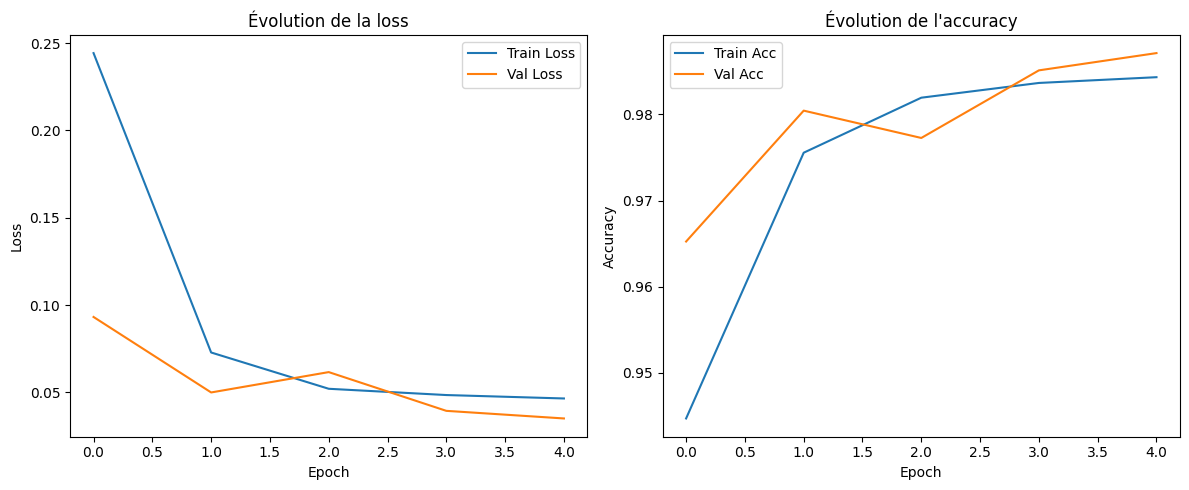

In [39]:
def plot_best_fold(best, path=None):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(best["train_losses"], label='Train Loss')
    plt.plot(best["val_losses"], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title("Évolution de la loss")
    
    plt.subplot(1,2,2)
    plt.plot(best["train_accs"], label='Train Acc')
    plt.plot(best["val_accs"], label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title("Évolution de l'accuracy")
    
    plt.tight_layout()
    if path is None:
        plt.show()
    else:
        plt.savefig(path + "/training_curves.png", dpi=200, bbox_inches='tight')
        plt.close()

plot_best_fold(best)

In [24]:
torch.save(model.state_dict(), "output/lcnn_weights.pth")

---

# Inference

In [25]:
def load_patch():
    x = 4500
    y = 1600
    width = 2000
    height = 2000
    
    files = ["BSE", "Fe", "S", "O", "Mg", "Ca", "Al", "Si"]
    images = load_images(x, y, width, height, files)
    
    features = [
        "BSE", "Ca", "Al", "Mg", "Si", "Fe", "S", "O",
        #"g Ca", "g Al",
        #"g BSE",
        #"g Mg", "g Si", "g Fe", "g S", "g O",
        #"= Mg / (Mg + Fe + Ca + 0.0000001)", "= Mg / (Si + + 0.0000001)", "= Mg / (Fe + + 0.0000001)","= Ca / (Al + 0.0000001)", "= Fe / (Si + + 0.0000001)"
    ]
    
    data = compute_features(images, features)
    
    pad = 0
    if pad > 0:
        data = np.pad(data, ((pad,pad),(pad,pad),(0,0)), mode='reflect')
    
    return data

data = load_patch()
print(data.shape)

(2000, 2000, 8)


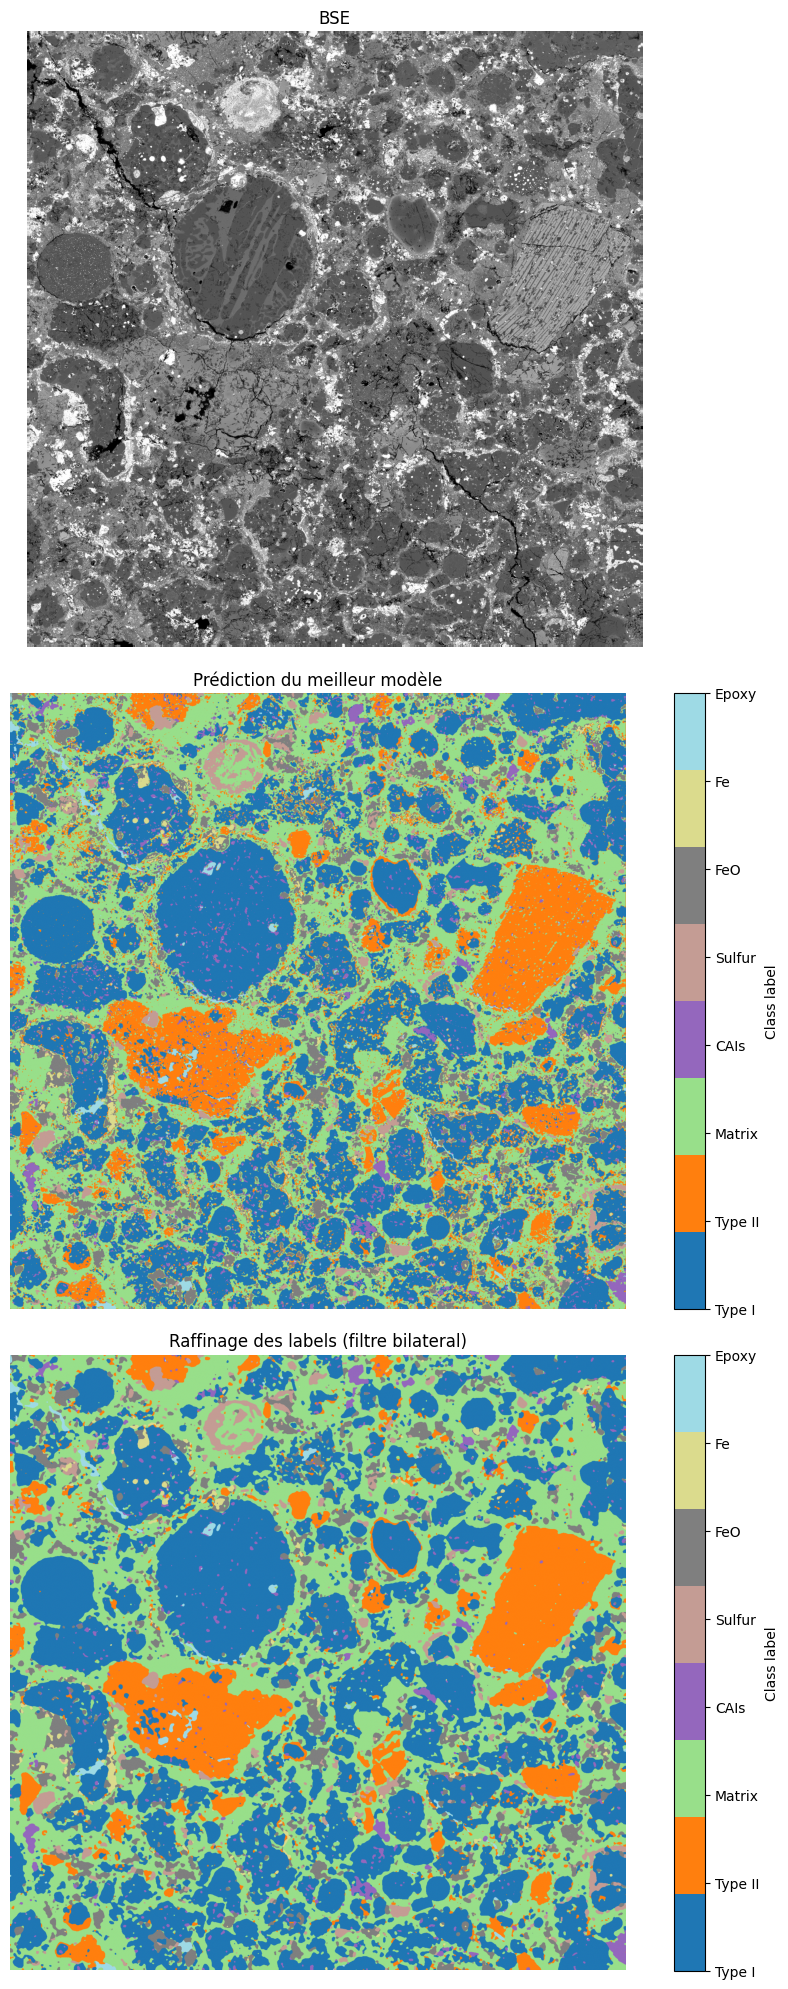

In [40]:
def refine_with_bilateral(data, probs, main_channel=0):
    guide = data[..., main_channel].astype(np.float32)
    guide = (guide - guide.mean()) / (guide.std() + 1e-5)

    refined = np.zeros_like(probs)

    for c in range(probs.shape[0]):
        refined[c] = cv2.bilateralFilter(
            probs[c].astype(np.float32),
            d=11,
            sigmaColor=20,
            sigmaSpace=10
        )

    return np.argmax(refined, axis=0)

def forward(data, model, path=None):
    pad = 3
    data = np.pad(data, ((pad,pad),(pad,pad),(0,0)), mode='reflect')
    
    x_input = torch.tensor(data, dtype=torch.float32).permute(2,0,1).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        logits = model(x_input)  # (1, num_classes, H_out, W_out)
        preds = torch.argmax(logits, dim=1).squeeze().cpu().numpy()
        probs = F.softmax(logits, dim=1)[0].cpu().numpy()

    labels_refined = refine_with_bilateral(
        data=data,
        probs=probs,
        main_channel=0
    )

    # Plotting
    plt.figure(figsize=(10,20))

    n_classes = len(labels)
    cmap = plt.get_cmap('tab20', n_classes)
    
    plt.subplot(3,1,1)
    plt.imshow(data[:,:,0], cmap='gray')
    plt.title("BSE")
    plt.axis('off')
    
    plt.subplot(3,1,2)
    im = plt.imshow(preds, cmap=cmap, vmin=0, vmax=n_classes-1)

    cbar = plt.colorbar(im, ticks=np.arange(n_classes))
    cbar.ax.set_yticklabels(labels)
    cbar.set_label("Class label")
    
    plt.title("Prédiction du meilleur modèle")
    plt.axis('off')

    plt.subplot(3,1,3)
    im = plt.imshow(labels_refined, cmap=cmap, vmin=0, vmax=n_classes-1)

    cbar = plt.colorbar(im, ticks=np.arange(n_classes))
    cbar.ax.set_yticklabels(labels)
    cbar.set_label("Class label")
    plt.title("Raffinage des labels (filtre bilateral)")
    plt.axis('off')
    
    plt.tight_layout()
    if path is None:
        plt.show()
    else:
        plt.savefig(path + "/inference.png", dpi=200, bbox_inches='tight')
        plt.close()

    return preds

res_labels = forward(data, model)

Le résultat est très clean, le filtre bilatéral permet de réduire un peu les pixels de bruit isolé tout en maintenant les bordures. Les carbonates ajoute quand même pas mal de bruit. On peut essayer de faire un hyper parameter search pour voir ce que ça donne. Par exemple tester:
- early fusion, mid fusion et late fusion
- faire varier la taille des patchs
- considérer que le pixel central pour la backprop
- virer les carbonates (encore)

In [32]:
np.save("output/classification.npy", res_labels)

---

# HP Search

In [48]:
import os
import json

os.makedirs("results", exist_ok=True)

def evaluate(agent, hp, name):
    base_dir = "results/" + name
    os.makedirs(base_dir, exist_ok=True)

    with open(base_dir + "/hp.json", "w") as f:
        json.dump(hp, f, indent=4)

    best = agent.fold_results[0]

    model = agent.model_cls().to(device)
    model.load_state_dict(best["model_state"])
    model.eval()
    
    test(X_test, y_test, model, device, base_dir) # matrice
    plot_best_fold(best, base_dir) # learning curves

    res_labels = forward(data, model, base_dir) # prediction
    np.save(base_dir + "/classification.npy", res_labels)

    torch.save(model.state_dict(), base_dir + "/lcnn_weights.pth")

In [53]:
import random
from datetime import datetime

search_space = {
    "model_type": ["EarlyCNN", "MidFusionCNN"],
    "early_latent_dims": [[16,32], [32,64], [16,32,64]],
    "mid_latent_dims_branch1": [[16,32], [32,64], [16,32,64]],
    "mid_latent_dims_branch2": [[16,32], [32,64], [16,32,64]],
    "mid_fusion_latent_dims": [[16], [32], [16,32]],
    "activation": ["relu", "gelu"],
    "batch_size": [32, 64],
    "lr": [1e-3, 5e-4],
    "center_mode": [True, False],
}

n_trials = 100
results = []

for trial in range(n_trials):
    print(f"---- Trial {trial} ----")
    hp = {k: random.choice(v) for k,v in search_space.items()}
    print(hp)
    
    # Crée le modèle
    if hp["model_type"] == "EarlyCNN":
        model_cls = lambda: EarlyCNN(
            in_channels=8,
            latent_dims=hp["early_latent_dims"],
            num_classes=8,
            activation=hp["activation"]
        )
    else:
        model_cls = lambda: MidFusionCNN(
            latent_dims_branch1=hp["mid_latent_dims_branch1"],
            latent_dims_branch2=hp["mid_latent_dims_branch2"],
            fusion_latent_dims=hp["mid_fusion_latent_dims"],
            num_classes=8,
            activation=hp["activation"]
        )
    
    # Génère un nom unique pour l'essai
    timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
    trial_name = f"{hp['model_type']}_trial{trial}_{timestamp}"
    
    # Crée l'Agent
    agent = Agent(
        model_cls=model_cls,
        device=device,
        center_mode=hp["center_mode"]
    )
    
    val_score = agent.cross_validate(
        X_train, y_train,
        k=1,
        num_epochs=100,
        batch_size=hp["batch_size"],
        lr=hp["lr"]
    )

    print(trial_name, end='')
    evaluate(agent, hp, trial_name)

    print(f"{trial_name}: score={agent.fold_results[0]['best_val_loss']:.4f}")

---- Trial 0 ----
{'model_type': 'MidFusionCNN', 'early_latent_dims': [16, 32, 64], 'mid_latent_dims_branch1': [16, 32, 64], 'mid_latent_dims_branch2': [16, 32], 'mid_fusion_latent_dims': [32], 'activation': 'relu', 'batch_size': 64, 'lr': 0.001, 'center_mode': False}
Epoch 1/100 | Train Loss: 0.1441, Acc: 0.9504 | Val Loss: 0.0313, Acc: 0.9893
Epoch 2/100 | Train Loss: 0.0316, Acc: 0.9894 | Val Loss: 0.0264, Acc: 0.9906
Epoch 3/100 | Train Loss: 0.0253, Acc: 0.9919 | Val Loss: 0.0179, Acc: 0.9933
Epoch 4/100 | Train Loss: 0.0234, Acc: 0.9927 | Val Loss: 0.0171, Acc: 0.9935
Epoch 5/100 | Train Loss: 0.0230, Acc: 0.9923 | Val Loss: 0.0233, Acc: 0.9916
Epoch 6/100 | Train Loss: 0.0180, Acc: 0.9938 | Val Loss: 0.0127, Acc: 0.9955
Epoch 7/100 | Train Loss: 0.0162, Acc: 0.9944 | Val Loss: 0.0111, Acc: 0.9960
Epoch 8/100 | Train Loss: 0.0177, Acc: 0.9946 | Val Loss: 0.0226, Acc: 0.9921
Epoch 9/100 | Train Loss: 0.0350, Acc: 0.9911 | Val Loss: 0.0114, Acc: 0.9958
Epoch 10/100 | Train Loss: 0.